<a href="https://colab.research.google.com/github/moulinath/Cloud-Certifications/blob/master/Automatic%20Ticket%20Classificaion_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import and install required packages

!pip3 install textblob
!pip3 install wordcloud
!pip3 install nltk
!pip3 install xgboost
!pip3 install catboost

# Libraries for data loading and manipulation
import pandas as pd
import numpy as np
import json
import pickle


# Libraries for data visualization and EDA
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS


# Libraries for text preprocessing
import re, nltk, spacy, string
nlp = spacy.load("en_core_web_sm")
# from subprocess import check_output
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


# Libraries for machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# Libraries for evaluating models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

## Set limits for displaying rows and columns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Converting Json to Dataframe

In [2]:
# Opening JSON file 
#f = open('/content/complaints.json',)
  
# returns JSON object as  
# a dictionary 
# data = json.load(f)
#df=pd.json_normalize(data)

with open ('/content/complaints.json',) as f:
   data = json.load(f)
df=pd.json_normalize(data)

Data Understanding

In [3]:
# Inspect dataframe
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
# View dataframe dimensions
df.shape

(78313, 22)

In [5]:
# Print column names

list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

We will remove the leading underscore as part of the data cleaning


In [6]:
# View column info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

We will have to treat the columns wth missing values

In [7]:
# View statistical info of the numerical column
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


_Score has all '0's

In [9]:
# Inspect the number of missing values
df.isna().sum(0)

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

There are multiple columns with missing values. Given these may not have any impact on the model building process, we can leave these untreated

Data Cleaning

Renaming the column headers by removing the leading underscored

In [10]:
df.columns = [re.sub('^_', '', col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'source.tags',
 'source.zip_code',
 'source.complaint_id',
 'source.issue',
 'source.date_received',
 'source.state',
 'source.consumer_disputed',
 'source.product',
 'source.company_response',
 'source.company',
 'source.submitted_via',
 'source.date_sent_to_company',
 'source.company_public_response',
 'source.sub_product',
 'source.timely',
 'source.complaint_what_happened',
 'source.sub_issue',
 'source.consumer_consent_provided']

In [11]:
## Remove 'source' from column names beginning with 'source.'
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [12]:
# View dataframe with corrected column names
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


Identifying and removing blank complaint rows

In [13]:
# Counting number of rows with blank under complaints column 
len(df[df['complaint_what_happened'] == ""])

57241

To remove the rows containing blanks, we will first replace them by NaNs and then remove missing values.

In [14]:
# Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

# Again counting number of rows with blank under complaints column 
len(df[df['complaint_what_happened'] == ""])

0

In [15]:
## View the shape of modified dataframe
df.shape

(21072, 22)

Thus we have successfully removed the 57241 blank complaint rows (78313-57241=21072)

Data Preprocessing

As part of data pre-processing prior to topic modeling, we will -

1. Convert the text into lowercase
2. Remove text in square brackets
3. Remove all punctuation
4. Remove all words containing numbers

In [16]:
## View first five rows of complaint column
df['complaint_what_happened'].head()

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [123]:
# Function here to clean the text and remove all the unnecessary elements.
def cleaned_txt(text):
    '''This function 
        - makes the given text lowercase
        - removes text in square brackets
        - removes all punctuation and 
        - removes all words containing numbers.
    :param text: text to be cleaned
    :return: cleaned text
    '''
    
    # Make the text lowercase
    text = text.lower()
    
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove all punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove all words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [124]:
# Apply the above function to complaint column and create a new dataframe containing only text-cleaned complaints
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: cleaned_txt(x)))

# View first five rows of text-cleaned dataframe
df_clean.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase


Now we will:
1. Lemmatize all the text
2. Use POS tags to get only relevant words from the texts.

In [125]:
#Write your function to Lemmatize the texts
def func_lemmatizer(text):     
    """
    This function lemmatizes the given input text.
    :param text: given text
    :return: lemmatized text
    """
    
    # Initialize empty list to store lemmas
    sent = []
    
    # Extract lemmas of given text and add to the list 'sent'
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(sent)

In [126]:
# Add a column for lemmatized complaints to the dataframe
df_clean["lemmatized_complaint"] =  df_clean.apply(lambda x: func_lemmatizer(x['complaint_what_happened']), axis=1)

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not st

We will extract singular nouns from the lemmatized complaints


In [127]:
# Extract singular nouns

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def get_singular_noun(text):
    """
    This function extracts the singular nouns from given text
    :param: input text
    :return: extracted nouns from the input text
    """
    
    # Create a textblob object
    blob = TextBlob(text)
    
    # extract words with tags 'NN', join them and return
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

# Apply the function to create a new column containing only singular nouns 
# We don't have plural nouns as the text is already lemmatized
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_singular_noun(x['lemmatized_complaint']), axis=1)

# View the dataframe
df_clean.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my infor

Data Analysis - we will do the following : 

1. Visualize the data according to the 'Complaint' character length
2. Use a word cloud to  find the top 50 words by frequency among all the articles after processing the text
3. Find the top unigrams, bigrams and trigrams by frequency among all the complaints after processing the text.

In [128]:
# Create list of lengths of pre-processed complaints
doc_length = [len(d) for d in df_clean['complaint_POS_removed']]
doc_lens[:5]

[159, 105, 74, 414, 161]

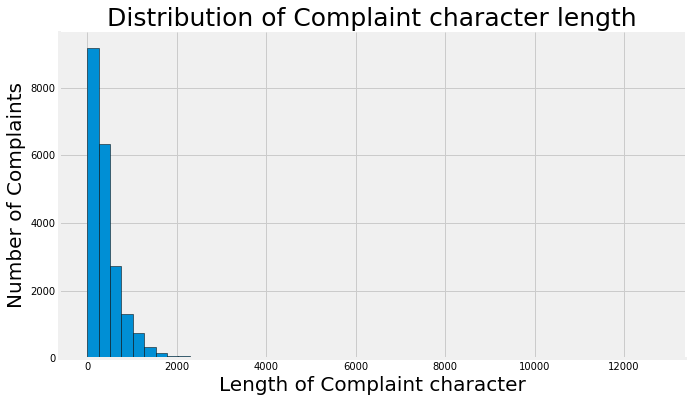

In [129]:
# Plot the data according to character length of complaints
plt.figure(figsize=(10,6))
plt.hist(doc_length, edgecolor='black', bins = 50)
plt.title('Distribution of Complaint character length', fontsize=25)
plt.ylabel('Number of Complaints', fontsize=20)
plt.xlabel('Length of Complaint character', fontsize=20)
sns.despine()
plt.show()

Distribution looks to be relatively Normal 

Plot the top 50 words by frequency using a word cloud 

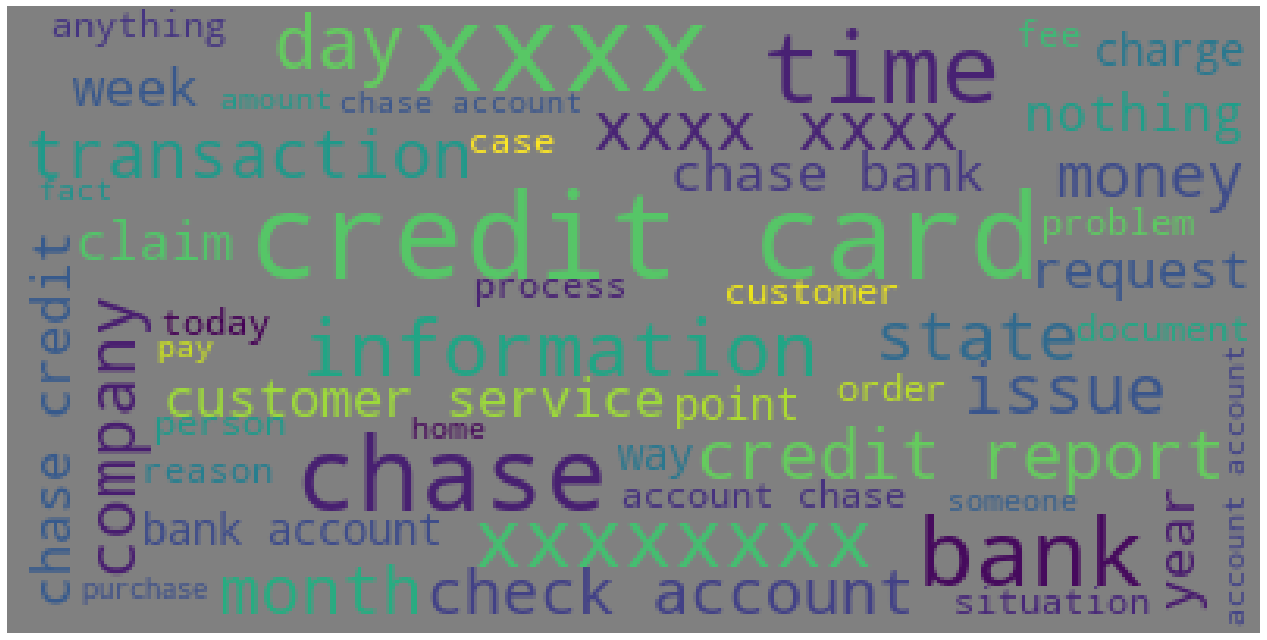

In [130]:
#Using a word cloud, we plot the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='grey',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Credit Card looks to be occurring the maximum no. of times. However, we will analyze the unigram, bigram and trigram

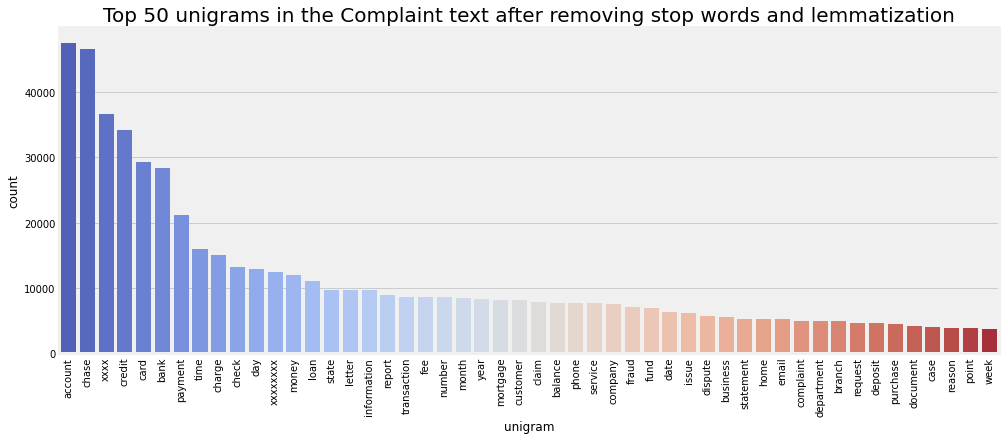

,unigram,count
0,account,47488
1,chase,46549
2,xxxx,36539
3,credit,34141
4,card,29274
5,bank,28401
6,payment,21167
7,time,16022
8,charge,14992
9,check,13156


In [134]:
# We will now find the top 50 unigram frequency among the complaints in the cleaned dataframe(df_clean). 
def get_top_number_unigram(corpus, n=None):
    """
    This function takes a corpus of words (text) and returns the top n words(unigrams) among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top words(unigrams) to find
    :return: list of tuples with two elements each: the word and its frequency
    """
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Top 50 unigrams by frequency among all the complaints
common_words = get_top_number_unigram(df_clean['complaint_POS_removed'].values.astype('U'), 50)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

# Plot the top 50 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df2, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 50 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

# View top 15 unigrams
df2.head(15)

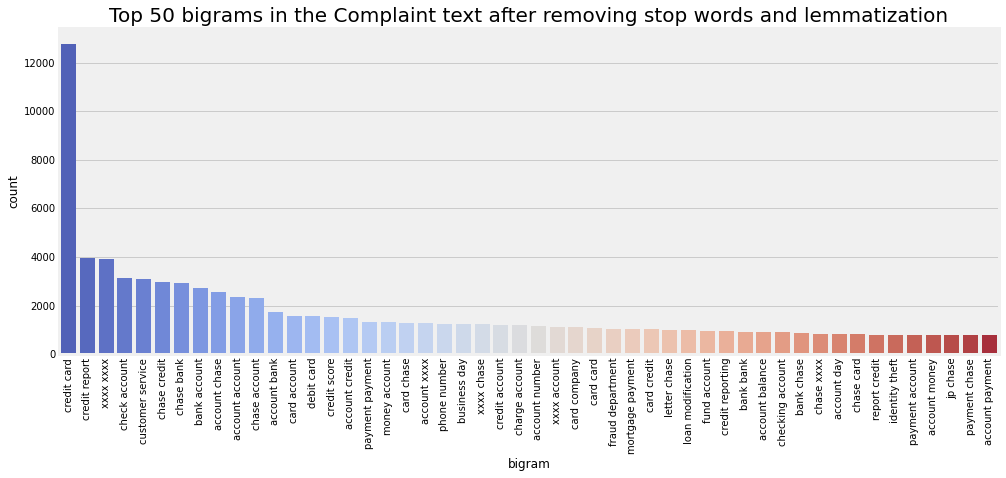

,bigram,count
0,credit card,12777
1,credit report,3947
2,xxxx xxxx,3937
3,check account,3146
4,customer service,3081
5,chase credit,2962
6,chase bank,2938
7,bank account,2728
8,account chase,2579
9,account account,2357


In [132]:
# We will now find the top 50 bigram frequency among the complaints in the cleaned dataframe(df_clean). 
def get_top_number_bigram(corpus, n=None):
    """
    This function takes a corpus of words (text) and returns the top n bigrams among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top bigrams to find
    :return: list of tuples with two elements each: the bigram and its frequency
    """
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


# Top 50 bigrams by frequency among all the complaints
common_words = get_top_number_bigram(df_clean['complaint_POS_removed'].values.astype('U'), 50)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

# Plot the top 50 bigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df3, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 50 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()


#View Top 15 Bigrams
df3.head(15)

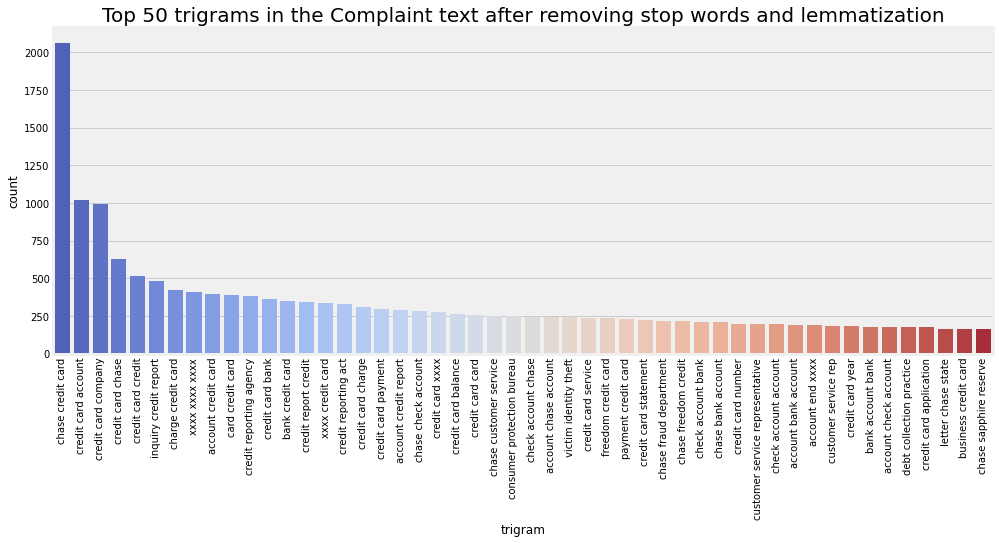

,trigram,count
0,chase credit card,2062
1,credit card account,1018
2,credit card company,991
3,credit card chase,630
4,credit card credit,514
5,inquiry credit report,480
6,charge credit card,423
7,xxxx xxxx xxxx,409
8,account credit card,398
9,card credit card,386


In [133]:
# We will now find the top 50 trigram frequency among the complaints in the cleaned dataframe(df_clean). 
def get_top_number_trigram(corpus, n=None):
    """
    This function takes a corpus of words (text) and returns the top n trigrams among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top trigrams to find
    :return: list of tuples with two elements each: the trigram and its frequency
    """
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


# Top 50 trigrams by frequency among all the complaints
common_words = get_top_number_trigram(df_clean['complaint_POS_removed'].values.astype('U'), 50)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

# Plot the top 50 Trigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df4, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 50 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()


# View Top 15 Trigrams
df4.head(15)

In [28]:
# Remove all masks 'xxxx' from complaints
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

# View final pre-processed data
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the

Feature Extraction

Convert the raw text to a matrix of TF-IDF features

In [29]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])

Topic Modeling using NMF

In [135]:
!pip install gensim==4.1.0
# Use Coherence model to find best number of topics
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_POS_removed']
dataset = [d.split() for d in texts]

# Create a dictionary

dictionary = Dictionary(dataset)

# Filter extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
       w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
       
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score


scores = list(zip(topic_nums, coherence_scores))
best_number_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_number_topics)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
5


Manual Topic Modeling

In [32]:
# Load nmf_model with n_components set to 5
nmf_model = NMF(n_components=5, random_state=40)

# Fit the model on document term matrix
nmf_model.fit(dtm)

# View the number of features
len(tfidf.get_feature_names())



7254

In [33]:
# Print the Top 25 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 25 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 25 WORDS FOR TOPIC #0
['debit', 'state', 'checking', 'information', 'phone', 'reason', 'time', 'fraud', 'access', 'cash', 'customer', 'transfer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


THE TOP 25 WORDS FOR TOPIC #1
['service', 'theft', 'agency', 'point', 'history', 'time', 'reason', 'identity', 'bureaus', 'reporting', 'year', 'balance', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 25 WORDS FOR TOPIC #2
['representative', 'customer', 'thought', 'end', 'option', 'report', 'plan', 'history', 'car', 'error', 'mortgage', 'year', 'chase', 'account', 'credit', 'pay', 'date', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']


THE TOP 25 WORDS FOR TOPIC #3
['letter', 'month', 'balance', 'department', 'debit', 'state', 'customer', 'email', 'day', 'phone', 'company', 'refund'

In [136]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

# Create a new 'Topic' column and assign the best topic to each of the complaints

df_clean['Topic'] = topic_result.argmax(axis=1)

# View the feature matrix
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put

In [47]:
# Print the first 10 Complaint for each of the Topics
df_clean5 = df_clean.groupby('Topic').head(10)

df_clean5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
24,mishandling of this account by chase auto and xxxx,mishandle of this account by chase auto and xxxx,mishandle account auto,0
103,on xxxxxxxx i received an advertisement via email that new chase customers could get for opening a new chase total checking account with the set up direct deposit and an additional for new chase savings customers who open a chase savings account and deposit a total of or more in new money within business days and maintain a balance for days i careful read all of the disclosures and was sure to follow all steps correctly to be eligible for both offers to receive the combined offer i opened my accounts online on chase s website on xxxxxxxx to date xxxxxxxx i still have not received either offer despite numerous attempts to work with chase employees to resolve this on xxxxxxxx i deposited into the savings account well within the business days of account opening when i contacted chase at the end of xxxx to discuss my concern i called the customer service line and spoke with a supervisor he informed me there was nothing he could do without the coupon code i explained i do not have the coupon code at the time and the call ended i later found the coupon code and called back during this call a lady informed me that regardless of having the coupon code there was nothing that could be done to investigateresolve this she then told me the reason i did not receive the bonus offers for opening either account is because i did not enter the coupon code at the time i opened the account online that was the only reason i did not receive the bonus amounts \n\nduring the online account opening process chase s website stated if you open the account online your coupon code will be automatically applied furthermore the email i received will be attached for reference specifically states your coupon code will be automatically applied account s subject to approval as a result two sources confirmed that the coupon code would be automatically applied therefore i dont recall entering the coupon because it was being added automatically for me \n\ni am very frustrated with my chase experience and the lack of payment of these bonus offers i rightfully earned after phone customer service supervisors told me there was nothing they could do i contacted local branch management they advised me to contact the phone customer service and said they could not help me i am very upset about this entire experience i want to be compensated to cover the and offers i should have earned i followed all of the terms and disclosures correctly please investigate this matter and contact me back thank you,on xxxxxxxx I receive an advertisement via email that new chase customer could get for open a new chase total checking account with the set up direct deposit and an additional for new chase saving customer who open a chase saving account and deposit a total of or more in new money within business day and maintain a balance for day I careful read all of the disclosure and be sure to follow all step correctly to be eligible for both offer to receive the combine offer I open my account online on chase s website on xxxxxxxx to date xxxxxxxx I still have not receive either offer despite numerous attempt to work with chase employee to resolve this on xxxxxxxx I deposit into the saving account well within the business day of account opening when I contact chase at the end of xxxx to discuss my concern I call the customer service line and speak with a supervisor he inform I there be nothing he could do without the coupon code I explain I do not have the coupon code at the time and the call end I later find the coupon code and call back during this call a lady inform I that regardless of have the coupon code there be nothing that could be do to investigateresolve this she then tell I the reason I do not receive the bonus offer for opening either account be because I do not enter the coup

After analyzing the first 10 complaints for the 5 topics, we wil assign names to topics as below
1. Topic 0: Bank Account issues
2. Topic 1: Credit card issues
3. Topic 2: Misc
4. Topic 3: Dispute 
5. Topic 4: Loan

In [137]:
#Create the dictionary of Topic names and Topics
Topic_name = {0:"Bank Account issues",
               1:"Credit card issues", 
               2:"Misc",
               3:"Dispute",
               4:"Loan"}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_name)

In [138]:
# View the feature matrix
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,Loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,Credit card issues
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,Credit card issues
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the tick

Model Building

In [139]:
# Create the dictionary again of Topic names and Topic numbers
Topic_name = {"Bank Account issues":0,
               "Credit card issues":1,
               "Misc":2,
               "Dispute":3,
               "Loan":4}

# Replace Topic Names with Topic numbers
df_clean['Topic'] = df_clean['Topic'].map(Topic_name)

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put

In [140]:
# Only retain  the columns"complaint_what_happened" & "Topic" in the new dataframe --> training_data
training_data = df_clean[["complaint_what_happened","Topic"]]

# View the training data
training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0


In [52]:
# View dimensions of training data
training_data.shape

(21072, 2)

In [53]:
# View value counts of the five topics
training_data['Topic'].value_counts()

0    5196
1    5013
3    4800
4    3804
2    2259
Name: Topic, dtype: int64

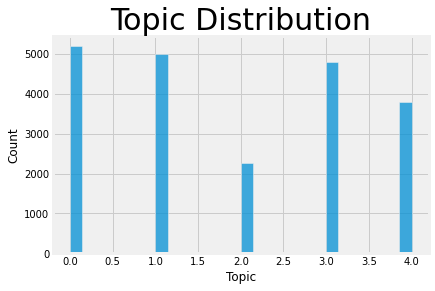

In [141]:
# Plot a histogram of topics
sns.histplot(data=training_data, x='Topic')
plt.title("Topic Distribution", fontsize=30)
plt.show()

We will consider F1 Score as our evaluation metric for comparing the performance of various models. 

We will use a weighted average method for evaluating F1 Score due to the imbalance of classes

We can now apply the supervised models on the training data created.

In this process, we will do the following:
1. Create the vector counts using Count Vectorizer
2. Transform the word vector to tf-idf
3. Create the train & test data using the train_test_split on the tf-idf & topics

In [143]:
# Get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

# Save Word Vector
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

# Transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Save TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

# Perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")


X_train Shape: (15804, 33599)
y_train Shape: (15804,)
X_test Shape: (5268, 33599)
y_test Shape: (5268,)


We will evaluate the following 4 models 

1. Logistic Regression
2. Naive Bayes
3. Decision Tree
4. XGBoost

In [146]:
# Create a function to evaluate models
def evaluate_model(y_test, y_pred, model_name):
    """
    This function prints the classification report of a classifier 
    and plots the confusion martrix
    :param y_test: actual labels
    :param y_pred: predicted labels
    :param model_name: the name of the model being evaluated
    :return: None
    """
    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account issues", "Credit card Issues", "Misc", "Dispute",
"Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,6))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account issues", "Credit card issues", "Misc", "Dispute",
"Loan"], yticklabels=["Bank Account issues", "Credit card issues", "Misc", "Dispute",
"Loan"])
    plt.show()
    
    return

Model 1 - Logistic Regression

In [147]:
# Run the Logistic Regression model
model_name = 'LOGISTIC REGRESSION'
clf_lr = LogisticRegression(solver='liblinear')
%time 
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11 µs


In [148]:
# Calculate F1 Score using weighted average method
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr
print(f"F1 Score of Logistic Regression Model : {f1_lr}")


F1 Score of Logistic Regression Model : 0.9182870972636542


In [67]:
# # Hyperparameter tuning to improve Logistic Regression performance
#param_grid_lr = {
#     'penalty': ['l1', 'l2','elasticnet', 'none'],
#     'C': [0.001,0.01,0.1,1,10,100],
#     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# }
#
#grid_lr = GridSearchCV(estimator=clf_lr, 
#                        param_grid=param_grid_lr,
#                        verbose=1,
#                        scoring='f1_weighted',
#                        n_jobs=-1,
#                        cv=5)
#grid_lr.fit(X_train, y_train)
#print(grid_lr.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


Keeping the code for hyperparameter tuning commented

Running Logistic Regression on hypertuned parameters

In [149]:
# Run Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')
%time 
clf_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [69]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned
print(f"F1 Score of Tuned Logistic Regression Model : {f1_lr_tuned}")

F1 Score of Tuned Logistic Regression Model : 0.9416478056049155


In [ ]:
Post tuning, F1 Score has improved from 0.92  to 0.94

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                     precision    recall  f1-score   support

Bank Account issues       0.94      0.96      0.95      1307
 Credit card Issues       0.95      0.95      0.95      1288
               Misc       0.93      0.95      0.94       555
            Dispute       0.94      0.91      0.92      1205
               Loan       0.94      0.95      0.94       913

           accuracy                           0.94      5268
          macro avg       0.94      0.94      0.94      5268
       weighted avg       0.94      0.94      0.94      5268



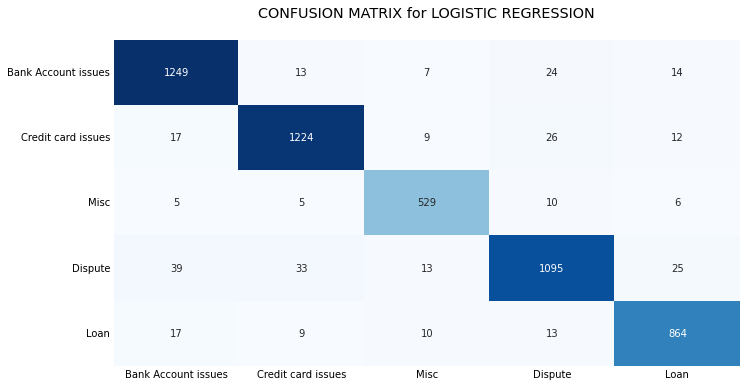

In [150]:
# Evaluate the tuned Logistic Regression classifier
evaluate_model(y_test, y_pred_lr_tuned, model_name)

The tuned Logistic Regression model gives a F1 score of 
0.94.

This model is performing well on all topics.

In [151]:
# Create a dataframe to store F1 Scores of all models we will build
summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score (untuned)': round(f1_lr, 2), 'F1 Score (tuned)': round(f1_lr_tuned, 2)}])
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.92,0.94


Model 2 - Naive Bayes

In [152]:
# Run the Multinomial Naive Bayes with default parameters
model_name = 'NAIVE BAYES'
clf_nb = MultinomialNB()
%time 
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


In [153]:
# Calculate F1 Score using weighted average method
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
f1_nb
print(f"F1 Score of Naive Bayes  Model : {f1_nb}")

F1 Score of Naive Bayes  Model : 0.6805213464799894


In [77]:
# # Hyperparameter tuning to improve Naive Bayes performance
#param_grid_nb = {
#     'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
#     'fit_prior':[True, False]
# }
#
#grid_nb = GridSearchCV(estimator=clf_nb, 
#                        param_grid=param_grid_nb,
#                        verbose=1,
#                        scoring='f1_weighted',
#                        n_jobs=-1,
#                        cv=10)
#grid_nb.fit(X_train, y_train)
#print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


Keeping the code for hyperparameter tuning commented

In [154]:
# Run Multinomial Naive Bayes on tuned hyperparameters
clf_nb_tuned = MultinomialNB(alpha=0.1, fit_prior=False)
%time 
clf_nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = clf_nb_tuned.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


In [155]:
# Calculate F1 Score of tuned model using weighted average method
f1_nb_tuned = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb_tuned
print(f"F1 Score of Tuned Naive Bayes  Model : {f1_nb_tuned}")

F1 Score of Tuned Naive Bayes  Model : 0.7820478002652672


Post tuning, F1 Score has improved from 0.68 to 0.78

CLASSIFICATION REPORT for NAIVE BAYES

                     precision    recall  f1-score   support

Bank Account issues       0.77      0.84      0.81      1307
 Credit card Issues       0.81      0.76      0.78      1288
               Misc       0.69      0.63      0.66       555
            Dispute       0.77      0.77      0.77      1205
               Loan       0.83      0.85      0.84       913

           accuracy                           0.78      5268
          macro avg       0.77      0.77      0.77      5268
       weighted avg       0.78      0.78      0.78      5268



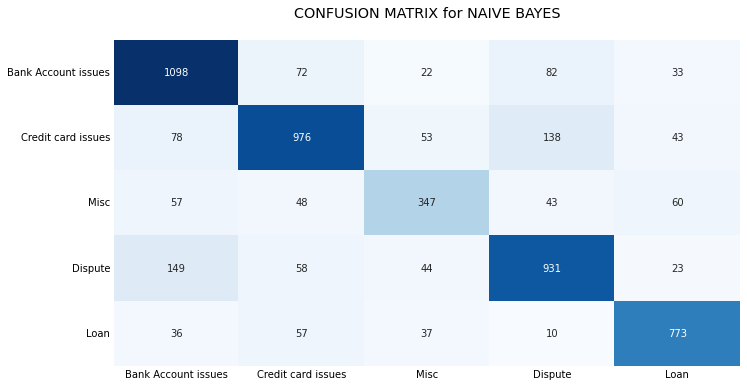

In [156]:
# Evaluate the tuned Naive Bayes classifier
evaluate_model(y_test, y_pred_nb_tuned, model_name)

The tuned Naive Bayes model gives a moderately well F1 score of 0.78.
However, this model performs comparatively poor on classifying Misc compared to remaining four topics.

In [157]:
# Update the summary table
summary.loc[len(summary.index)] = ['Naive Bayes', round(f1_nb, 2), round(f1_nb_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.92,0.94
1,Naive Bayes,0.68,0.78


Model 3 - Decision Tree

In [158]:
# Run Decision Tree on default hyperparameters
model_name = 'DECISION TREE'
clf_dt = DecisionTreeClassifier()
%time 
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


In [159]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt
print(f"F1 Score of Decision Tree  Model : {f1_dt}")

F1 Score of Decision Tree  Model : 0.7804655690496862


In [86]:
# # Hyperparameter tuning to improve Decision Tree performance
#param_grid_dt = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth' : [5, 10, 15, 20, 25, 30],
#     'min_samples_leaf':[1,5,10,15, 20, 25],
#     'max_features':['auto','log2','sqrt',None],
# }
#
#grid_dt = GridSearchCV(estimator=clf_dt, 
#                        param_grid=param_grid_dt,
#                        verbose=1,
#                        scoring='f1_weighted',
#                        n_jobs=-1,
#                        cv=5)
#grid_dt.fit(X_train, y_train)
#print(grid_dt.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
{'criterion': 'gini', 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 15}


Keeping the code for hyperparameter tuning commented

In [160]:
# Run Decision Tree on tuned hyperparameters
clf_dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=30, 
                                      min_samples_leaf=15, 
                                      max_features=None)
%time 
clf_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [161]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt_tuned
print(f"F1 Score of Tuned Decision Tree  Model : {f1_dt_tuned}")

F1 Score of Tuned Decision Tree  Model : 0.7961402091059071


Post tuning, the F1 Score of Decision Tree model has improved from 0.78 to 0.80

CLASSIFICATION REPORT for DECISION TREE

                     precision    recall  f1-score   support

Bank Account issues       0.79      0.81      0.80      1307
 Credit card Issues       0.82      0.82      0.82      1288
               Misc       0.80      0.77      0.79       555
            Dispute       0.76      0.73      0.75      1205
               Loan       0.81      0.84      0.82       913

           accuracy                           0.80      5268
          macro avg       0.80      0.80      0.80      5268
       weighted avg       0.80      0.80      0.80      5268



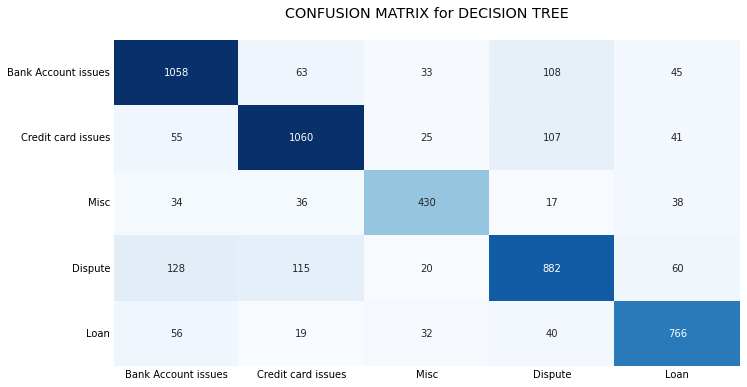

In [162]:
# Evaluate the tuned Decision Tree classifier
evaluate_model(y_test, y_pred_dt_tuned, model_name)

The tuned Decision Tree model gives a decent F1 score of 
0.80.
However, this model is performing marginally worse on Misc and Dispute as compared to the remaining 3 topics.


In [163]:
# Update the summary table
summary.loc[len(summary.index)] = ['Decision Tree', round(f1_dt, 2), round(f1_dt_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.92,0.94
1,Naive Bayes,0.68,0.78
2,Decision Tree,0.78,0.80


Model 4 - Support Vector Machine

In [164]:
# Run the Support Vector Machine (SVM) model on default hyperparameters
model_name = 'SUPPORT VECTOR MACHINE'
clf_svm = SVC()
%time 
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


In [165]:
# Calculate F1 Score using weighted average method
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")
f1_svm
print(f"F1 Score of Support Vector Machine  Model : {f1_svm}")

F1 Score of Support Vector Machine  Model : 0.914793781375747


In [104]:
# # Hyperparameter tuning to improve SVM performance
#param_grid_svm = {
#     'C': [10, 15],
#     'gamma': ['scale', 0.01],
#     'kernel': ['linear', 'rbf']
# }
#
#grid_svm = GridSearchCV(estimator=clf_svm, 
#                        param_grid=param_grid_svm,
#                        scoring='f1_weighted',
#                        verbose=1,
#                        n_jobs=-1,
#                        cv=2)
#grid_svm.fit(X_train, y_train)
#print(grid_svm.best_params_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
{'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}


Keeping the code for Hyperparameter Tuning commented

In [166]:
# Run SVM on tuned hyperparameters
clf_svm_tuned = SVC(C=10,
                    gamma='scale',
                    kernel='rbf')
%time 
clf_svm_tuned.fit(X_train, y_train)
y_pred_svm_tuned = clf_svm_tuned.predict(X_test)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [168]:
# Calculate F1 Score of tuned model using weighted average method
f1_svm_tuned = f1_score(y_test, y_pred_svm_tuned, average="weighted")
f1_svm_tuned
print(f"F1 Score of Tune Support Vector Machine  Model : {f1_svm_tuned}")

F1 Score of Tune Support Vector Machine  Model : 0.9144295746984836


Post tuning the F1 score has stayed the same as 0.91

CLASSIFICATION REPORT for SUPPORT VECTOR MACHINE

                     precision    recall  f1-score   support

Bank Account issues       0.91      0.94      0.93      1307
 Credit card Issues       0.92      0.92      0.92      1288
               Misc       0.93      0.88      0.90       555
            Dispute       0.90      0.88      0.89      1205
               Loan       0.91      0.93      0.92       913

           accuracy                           0.91      5268
          macro avg       0.92      0.91      0.91      5268
       weighted avg       0.91      0.91      0.91      5268



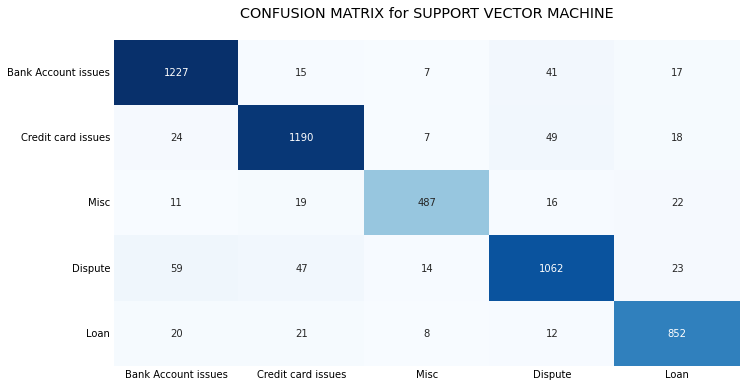

In [169]:
# Evaluate the SVM classifier
evaluate_model(y_test, y_pred_svm_tuned, model_name)

The SVM model gives a good F1 score of 0.91.
The model performs comparably well on all topics.

In [109]:
# Update the summary table
summary.loc[len(summary.index)] = ['Support Vector Machine', round(f1_svm, 2), round(f1_svm_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.92,0.94
1,Naive Bayes,0.68,0.78
2,Decision Tree,0.78,0.80
3,Support Vector Machine,0.91,0.91


So out of the 4 models evaluated, the tuned Logistic regression model performs the best

Testing the model with some sample data

In [170]:
# Save tuned Logistic Regression model as pickle file
pickle.dump(clf_lr_tuned, open("logreg_model.pkl", "wb"))

In [171]:
# Function to predict a topic for given text

def prediction_topic(text):
    
    target_names = ["Bank Account issues", "Credit card issues", "Misc", "Dispute", "Loan"]

    loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
    loaded_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_counts = loaded_vec.transform(text)
    X_new_tfidf = loaded_tfidf.transform(X_new_counts)
    predicted = loaded_model.predict(X_new_tfidf)

    return target_names[predicted[0]]

In [172]:
# Create a dataframe of some sample customer complaints
df_new = pd.DataFrame({'complaints': ["I talked to Chase and could not understand which bank is owning my mortgage currently.", 
                                  "I looked at my latest credit card statement and observed a fradulent transaction.I have raised a dispute and want to get it closed ASAP.",
                                  "I have joined a new job and they have recommended your Bank for my new salary account. Which branch should I go to ?",
                                  "I am getting unnecessary cold calls for a credit card that I do not want to sign up for, please put a stop to this.",
                                  "Can you please let me know how many branches does your Bank have in downtown Manhattan ?"]})
df_new

,complaints
0,I talked to Chase and could not understand which bank is owning my mortgage currently.
1,I looked at my latest credit card statement and observed a fradulent transaction.I have raised a dispute and want to get it closed ASAP.
2,I have joined a new job and they have recommended your Bank for my new salary account. Which branch should I go to ?
3,"I am getting unnecessary cold calls for a credit card that I do not want to sign up for, please put a stop to this."
4,Can you please let me know how many branches does your Bank have in downtown Manhattan ?


In [173]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_new['predicted topic'] = df_new['complaints'].apply(lambda x: prediction_topic([x]))
df_new

,complaints,predicted topic
0,I talked to Chase and could not understand which bank is owning my mortgage currently.,Loan
1,I looked at my latest credit card statement and observed a fradulent transaction.I have raised a dispute and want to get it closed ASAP.,Dispute
2,I have joined a new job and they have recommended your Bank for my new salary account. Which branch should I go to ?,Bank Account issues
3,"I am getting unnecessary cold calls for a credit card that I do not want to sign up for, please put a stop to this.",Credit card issues
4,Can you please let me know how many branches does your Bank have in downtown Manhattan ?,Bank Account issues


The model is working for sample data

So, we can adopt the tune Logistic Regression model. 